# Define Fruits&Vegetables


Также можно запустить на [Colab](https://colab.research.google.com/drive/1IAwLVVTw_TVEtJmz3olBBVzN_1OGaCR5?usp=sharing)

In [1]:
import os
import zipfile
from collections.abc import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch.utils.data.dataloader import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import VGG16_Weights
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
%matplotlib inline

## Загрузка датасета

In [2]:
import wandb
import zipfile

MAIN_DIR = '.'
DIR = MAIN_DIR + '/data/'

run = wandb.init(project="metric_learning")
artifact = run.use_artifact('balakinakate2022/metric_learning/fruits-dataset:v0', type='dataset')
artifact.download()

with zipfile.ZipFile(MAIN_DIR + '/artifacts/fruits-dataset:v0/fruits.zip', 'r') as zip_ref:
        zip_ref.extractall(DIR)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


wandb: Currently logged in as: balakinakate2022. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact fruits-dataset:v0, 2032.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:5.7


In [3]:
train_dir = MAIN_DIR + '/data/test'
val_dir = MAIN_DIR + '/data/validation'
test_dir = MAIN_DIR + '/data/test'
classes_unsorted = os.listdir(train_dir)
classes=sorted(classes_unsorted)
print(classes)

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


## Выделим названия и посмотрим содержание датасетов

In [4]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(100),              # resize shortest side
        transforms.CenterCrop(100),          # crop longest side
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [5]:
trainset = ImageFolder(train_dir, transform=train_transform)
valset = ImageFolder(val_dir, transform=train_transform)
testset = ImageFolder(test_dir, transform=train_transform)
print(len(trainset))

359


In [6]:
# function for the showing the image.
def show_image(img,label):
    print('Label: ', trainset.classes[label], "("+str(label)+")")
    img = np.clip(img, 0, 1)
    plt.imshow(img.permute(1,2,0))

['tomato', 'cabbage', 'pomegranate', 'carrot']


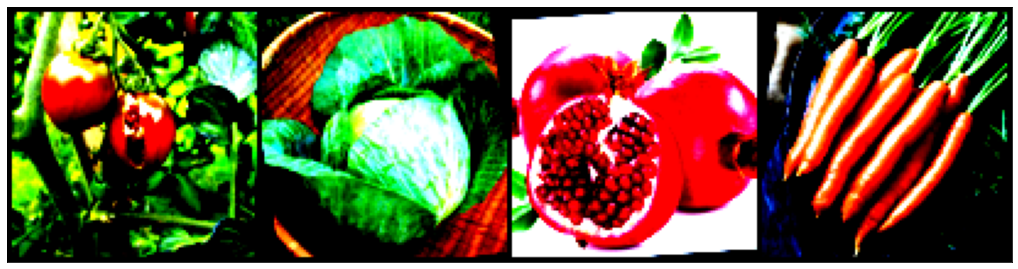

In [7]:
train_loader = DataLoader(trainset, 4, shuffle=True, num_workers=2, pin_memory=True)
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(np.clip(images, 0, 1),nrow=16).permute(1,2,0))
    print([trainset.classes[label] for label in labels])
    break

## Определим модель

In [13]:
class ImageClassificationBase(nn.Module):
    """
    Общий класс для модели.
     
    С методами обучения, валидации, вычисления средней accuracy
    """
    def training_step(self, batch: list, device: Callable) -> float:
        """
        Обучение на одном баче.

        Args:
            batch: один батч
            device: 'cpu' или 'cuda'
        Returns:
            значение функции потерь
        """
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                   # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss
    
    def validation_step(self, batch: list, device: Callable) -> dict:
        """
        Валидация на одном баче.

        Args:
            batch: один батч
            device: 'cpu' или 'cuda'
        Returns:
            val_loss и val_acc
        """
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs: list) -> dict:
        """
        Вычисление средних значений функции потерь и accurancy
        на валидационной выборке.

        Args:
            outputs: результат выданный моделью

        Returns: 
            словарь с loss и accuracy
        """
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        wandb.log({'val_loss_epoch': epoch_loss, 'val_acc_epoch': epoch_acc})
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

class VggModel(ImageClassificationBase):
    """Класс для модели на основе VGG16."""
    def __init__(self, number_output_classes: int):
        """
        Конструктор модели.

        Args:
            number_output_classes: количество классов, которые должны определяться
        """
        super().__init__()
        self.network = self.build_network(number_output_classes)

    def forward(self, xb):
        return self.network(xb)

    def build_network(self, number_output_classes: int) -> nn.Module:
        """
        Создание модели.

        За основу взята VGG16, в ней веса не будут меняться.
        Добавляются полносвязные слои, в ней веса при обучении меняются. 

        Args:
            number_output_classes: количество классов, которые должны определяться

        Returns:
            модель
        """
        model_extractor = models.vgg16(weights=VGG16_Weights.DEFAULT)

        # замораживаем параметры (веса)
        for param in model_extractor.parameters():
            param.requires_grad = False

        # num_features -- это размерность вектора фич, поступающего на вход FC-слою
        num_features = 25088
        # Заменяем Fully-Connected слой на наш линейный классификатор
        model_extractor.classifier =  nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, 10000), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(10000, 3000), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(3000, 1000), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, 500), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(500, number_output_classes)
        )
        return model_extractor


 ## Вспомогательные функции

In [14]:
def seed_everything(seed: int):
    """
    Make default settings for random values.

    Args:
        seed (int): seed for random
    """
    import os
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True 
    # будет работать - если граф вычислений не будет меняться во время обучения
    torch.backends.cudnn.benchmark = True  # оптимизации


def accuracy(outputs, labels):
    """
    Calculate accuracy. 

    Args:
        outputs: result of model
        labels: true result
    Returns:
        number
    """
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

@torch.no_grad()
def evaluate(model: nn.Module, val_loader: DataLoader, device: Callable) -> dict:
    """
    Evaluate result that model gives.
    
    Args:
        model (nn.Module): model that is used
        val_loader (DataLoader): dataloader for validation
        device (Callable): 'cpu' or 'cuda'
    Returns:
        val_loss and val_accuracy
    """
    model.eval()
    outputs = [model.validation_step(batch, device) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def model_learning(epochs: int,  lr: float, batch_size: int, model: nn.Module, opt_func: Callable, device: Callable):
    """
    Make learning of model for epochs.

    Args:
        epochs: number of epochs
        lr: learning rate
        batch_size: size of batch    
        model: current model
        opt_func: optimize function
        device: set 'cpu' or 'cuda'
    """

    trainset = get_trainset()
    valset = get_valset()
    optimizer = opt_func(model.parameters(), lr)
    train_loader = DataLoader(trainset, batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(valset, batch_size, num_workers=2)
    best_val_loss = 100
    best_val_acc = 0
    for epoch in range(epochs):
        if epoch%10 == 9:
            lr/=10
            optimizer = opt_func(model.parameters(), lr)
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch, device)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader, device)

        if best_val_loss >= result['val_loss'] and best_val_acc <= result['val_acc']:
            if (os.path.exists(MAIN_DIR + '/outs') == False):
                os.mkdir(MAIN_DIR + '/outs')
            best_val_loss = result['val_loss'] 
            best_val_acc = result['val_acc'] 
            torch.save(model.state_dict(), MAIN_DIR + '/outs/best_model.pth')

        result['train_loss'] = torch.stack(train_losses).mean().item()
        wandb.log({"train_loss_epoch": result['train_loss']})


transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(100),              # resize shortest side
        transforms.CenterCrop(100),          # crop longest side
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

def get_trainset() -> ImageFolder:
    """
    Creating dataset for test for training.

    Returns:
        dataset for test
    """
    train_dir = MAIN_DIR + '/data/train'
    return ImageFolder(train_dir, transform=transform)

def get_valset() -> ImageFolder:
    """
    Creating dataset for validation while training.

    Returns:
        dataset for validation
    """
    val_dir = MAIN_DIR + '/data/validation'
    return ImageFolder(val_dir, transform=transform)

def get_testset() -> ImageFolder:
    """
    Creating dataset for test.

    Returns:
        dataset for test
    """
    test_dir = MAIN_DIR + '/data/test'
    return ImageFolder(test_dir, transform=transform)

In [10]:
def  train_model( 
        config: dict,
        device: Callable = torch.device('cpu'),
    ):
    """
    Build all together: initialize the model,
    optimizer and loss function.

    Args:
        config(dict): set of hyperparameters
        device : set "cpu" or "cuda"
    """

    wandb.login()
    with wandb.init(project="metric_learning",config=config):
        config = wandb.config
        seed_everything(config.seed)
        train_dir = MAIN_DIR + '/data/train'
        device = get_default_device()
        count_classes = len(os.listdir(train_dir))
        model = VggModel(count_classes).to(device)
        opt_func = torch.optim.Adam
        model_learning(config.epochs, config.lr, config.batch_size, model,  opt_func, device)

def train():
    """ Определение гиперпараметров, запуск обучения. """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    config_for_training = dict(
        architecture = "VGG",  
        dataset = "fruits",
        epochs = 10,
        batch_size = 16,
        lr= 0.0003,
        seed =42
    )
    train_model(config_for_training, device=device)


In [11]:
train()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


  0%|          | 0/195 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/195 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/195 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/195 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/195 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/195 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/195 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/195 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/195 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/195 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train_loss_epoch,█▅▃▃▂▂▂▂▂▁
val_acc_epoch,▁▄▆▆▇▇▇▇██
val_loss_epoch,█▅▃▃▃▂▂▂▁▁
train_loss_epoch,0.48656
val_acc_epoch,0.92045
val_loss_epoch,0.24245


## Проверим accuracy на тестовой выборке

In [15]:
def test():
    """Вычисление accuracy на тестовой выборке."""
    wandb.login()
    with wandb.init(project="metric_learning"):
        testset = get_testset()
        test_loader = DataLoader(testset, 4, num_workers=2)
        device = get_default_device()
        train_dir = MAIN_DIR + '/data/test'
        count_classes = len(os.listdir(train_dir))
        model = VggModel(count_classes).to(device)
        model.load_state_dict(torch.load(MAIN_DIR + '/outs/best_model.pth'))
        model.eval()
        evaluate(model, test_loader, device)
        
        
test()

val_acc_epoch,▁
val_loss_epoch,▁
val_acc_epoch,0.92222
val_loss_epoch,0.22766
